In [1]:
!pip install -U tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


# Lung segmentation from Chest X-Ray dataset

**About the data**:
- The dataset is made up of images and segmentated mask from two diffrent sources.
- There is a slight abnormality in naming convention of masks.
- Some images don't have their corresponding masks.
- Images from the Shenzhen dataset has apparently smaller lungs as compared to the Montgomery dataset.


## Take a look at the dataset

In [2]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

2024-05-13 09:10:50.313393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 09:10:50.313513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 09:10:50.452376: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:


# Specify the paths for the new dataset
covid_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"
covid_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks"
lung_opacity_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images"
lung_opacity_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks"
normal_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images"
normal_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks"
viral_pneumonia_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images"
viral_pneumonia_mask_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/masks"

# Define a function to load and preprocess the new dataset
def getData(dataset_path, mask_path, X_shape, limit=1346):
    im_array = []
    mask_array = []

    dataset_files = set(os.listdir(dataset_path)) & set(os.listdir(mask_path))

    for i in tqdm(dataset_files):
        im = cv2.resize(cv2.imread(os.path.join(dataset_path, i)), (X_shape, X_shape))[:,:,0]
        mask = cv2.resize(cv2.imread(os.path.join(mask_path, i)), (X_shape, X_shape))[:,:,0]

        im_array.append(im)
        mask_array.append(mask)

        # Check if the limit is reached for each class
        if len(im_array) >= limit:
            break

    return im_array, mask_array

# Load and preprocess each category of the new dataset
dim = 256
X_covid, y_covid = getData(covid_path, covid_mask_path, dim)
X_lung_opacity, y_lung_opacity = getData(lung_opacity_path, lung_opacity_mask_path, dim)
X_normal, y_normal = getData(normal_path, normal_mask_path, dim)
X_viral_pneumonia, y_viral_pneumonia = getData(viral_pneumonia_path, viral_pneumonia_mask_path, dim)

# Convert lists to numpy arrays
X_covid = np.array(X_covid).reshape(len(X_covid), dim, dim, 1)
y_covid = np.array(y_covid).reshape(len(y_covid), dim, dim, 1)
X_lung_opacity = np.array(X_lung_opacity).reshape(len(X_lung_opacity), dim, dim, 1)
y_lung_opacity = np.array(y_lung_opacity).reshape(len(y_lung_opacity), dim, dim, 1)
X_normal = np.array(X_normal).reshape(len(X_normal), dim, dim, 1)
y_normal = np.array(y_normal).reshape(len(y_normal), dim, dim, 1)
X_viral_pneumonia = np.array(X_viral_pneumonia).reshape(len(X_viral_pneumonia), dim, dim, 1)
y_viral_pneumonia = np.array(y_viral_pneumonia).reshape(len(y_viral_pneumonia), dim, dim, 1)

# Concatenate data from all categories
X_data = np.concatenate((X_covid, X_lung_opacity, X_normal, X_viral_pneumonia), axis=0)
y_data = np.concatenate((y_covid, y_lung_opacity, y_normal, y_viral_pneumonia), axis=0)

# Print shapes of the concatenated datasets
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)


2024-05-12 10:02:37.998913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 10:02:37.999022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 10:02:38.132612: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 1345/1345 [00:34<00:00, 39.45it/s]


X_data shape: (5383, 256, 256, 1)
y_data shape: (5383, 256, 256, 1)


In [3]:
#perform sanity check

def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i],cmap="gray")
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1],cmap="gray")
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2],cmap="gray")
        
        plt.show()

training set


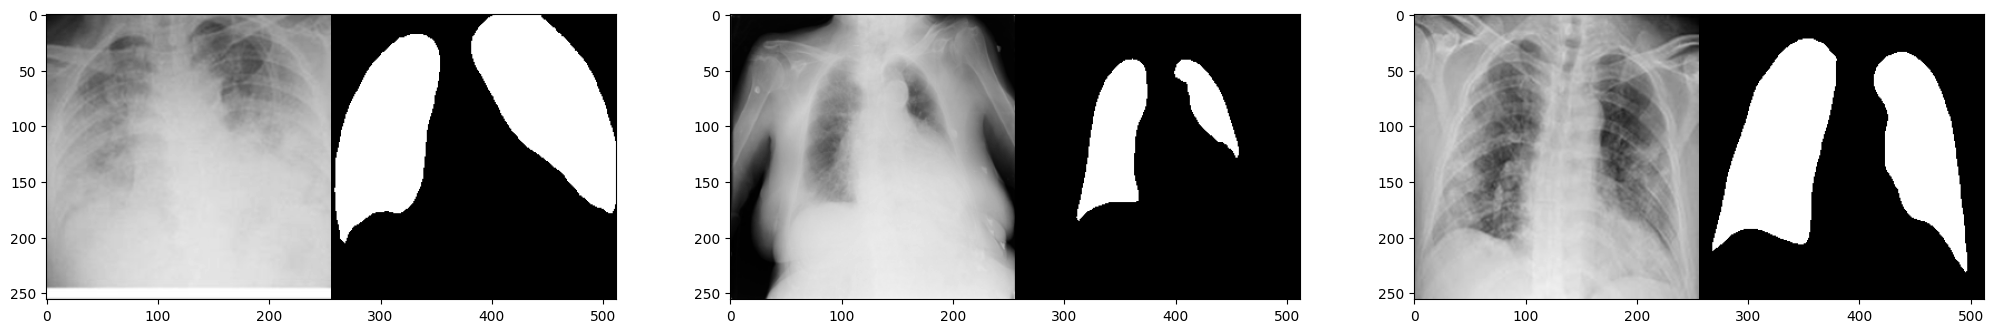

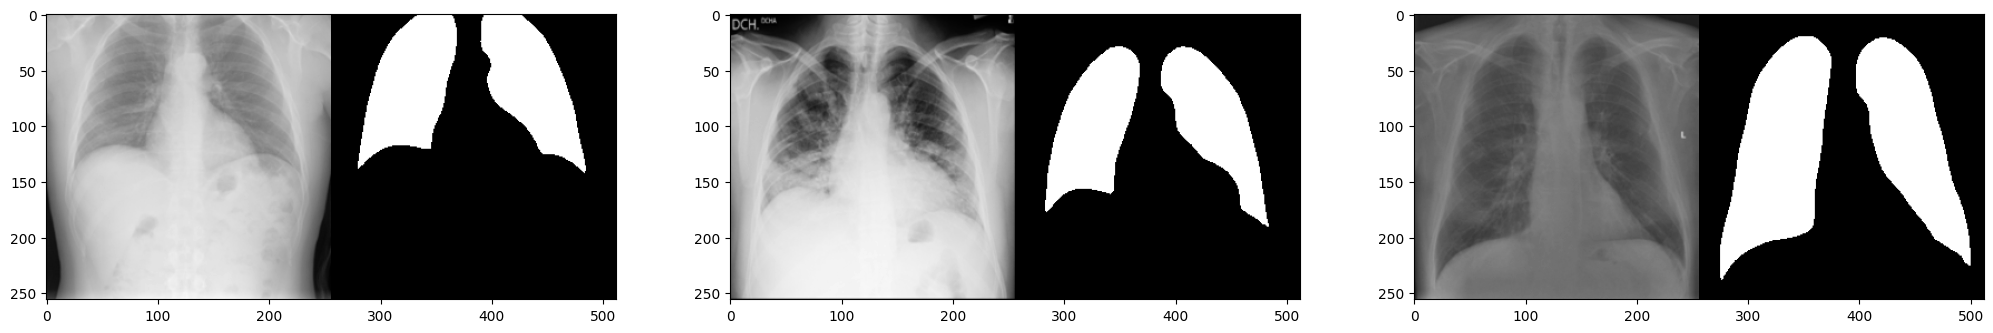

testing set


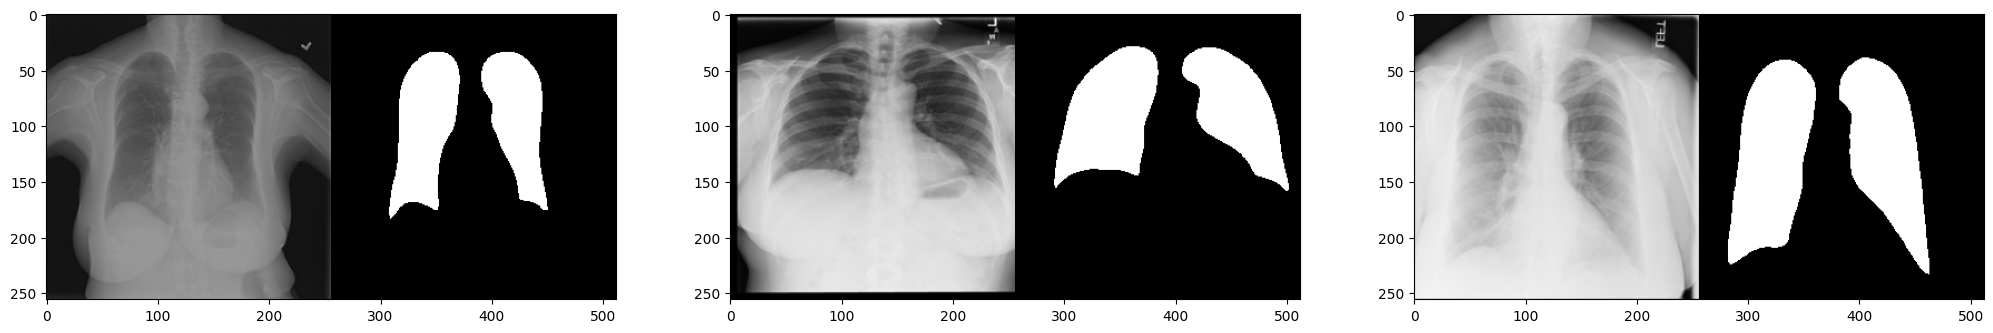

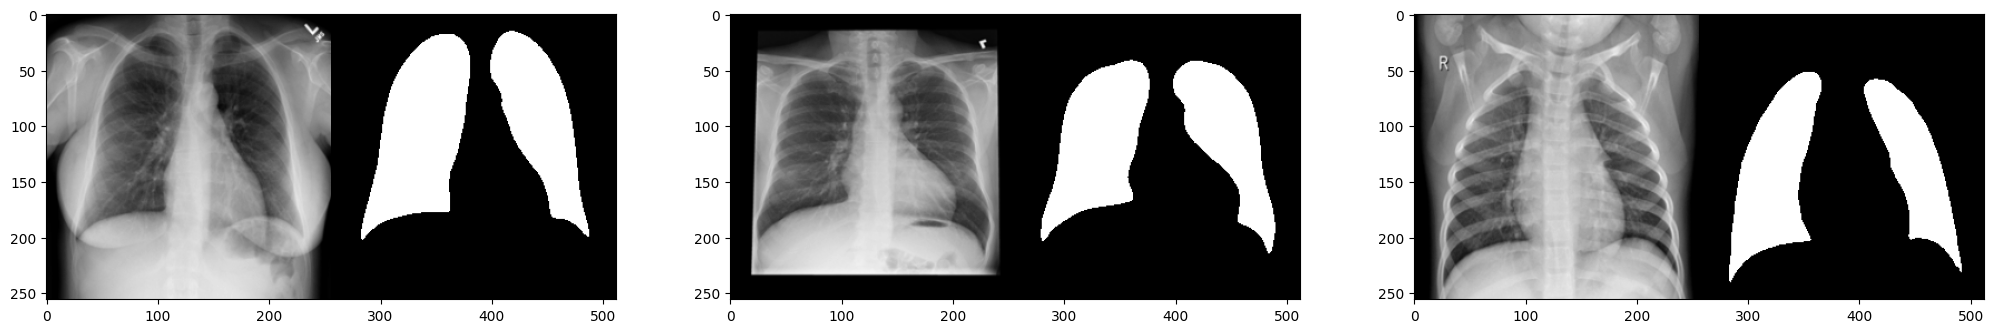

training set


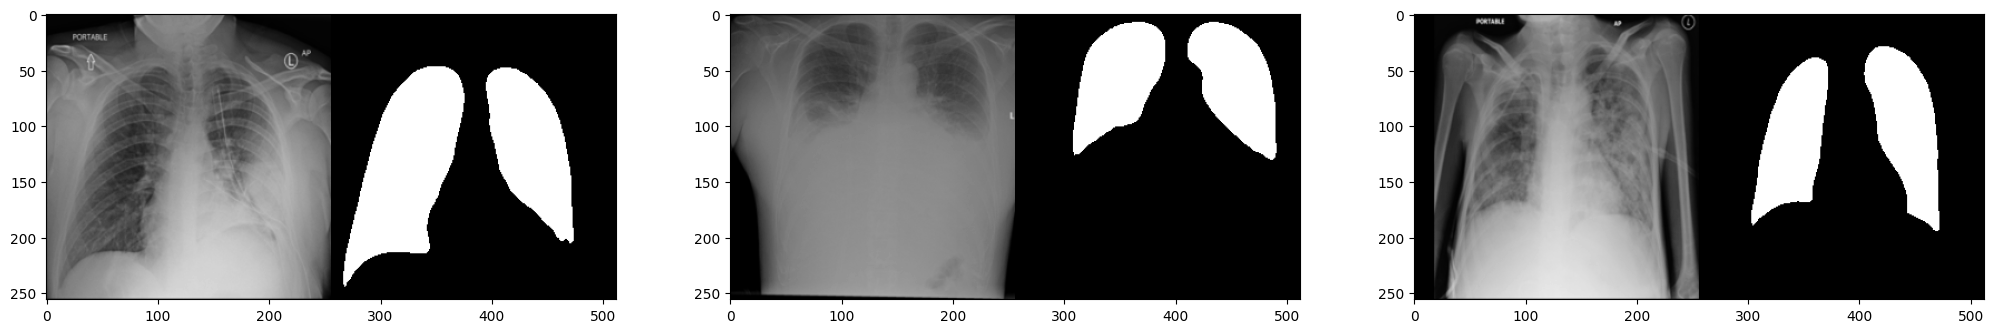

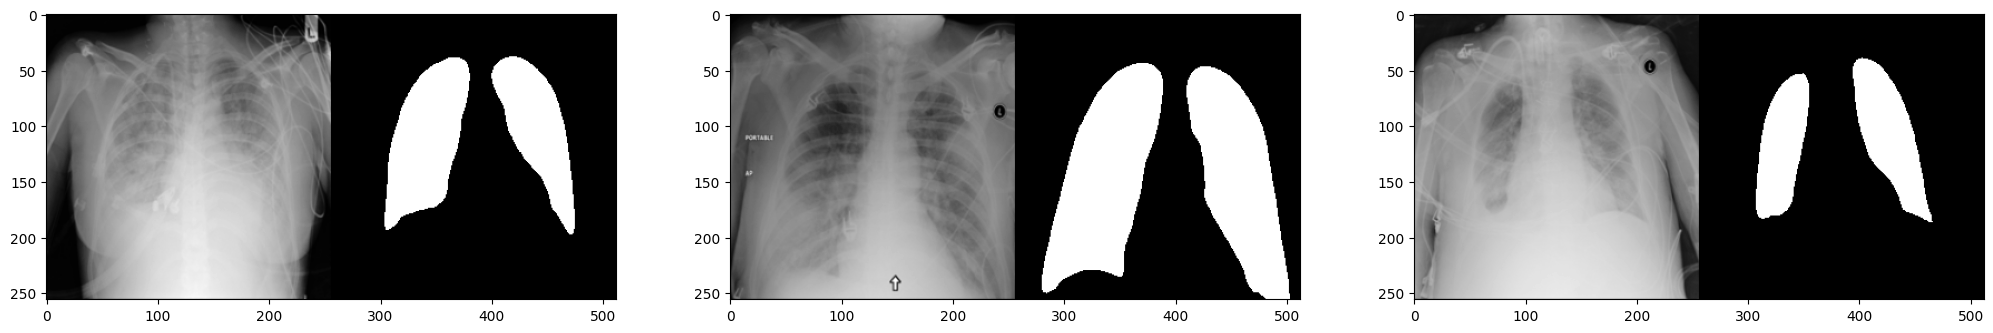

testing set


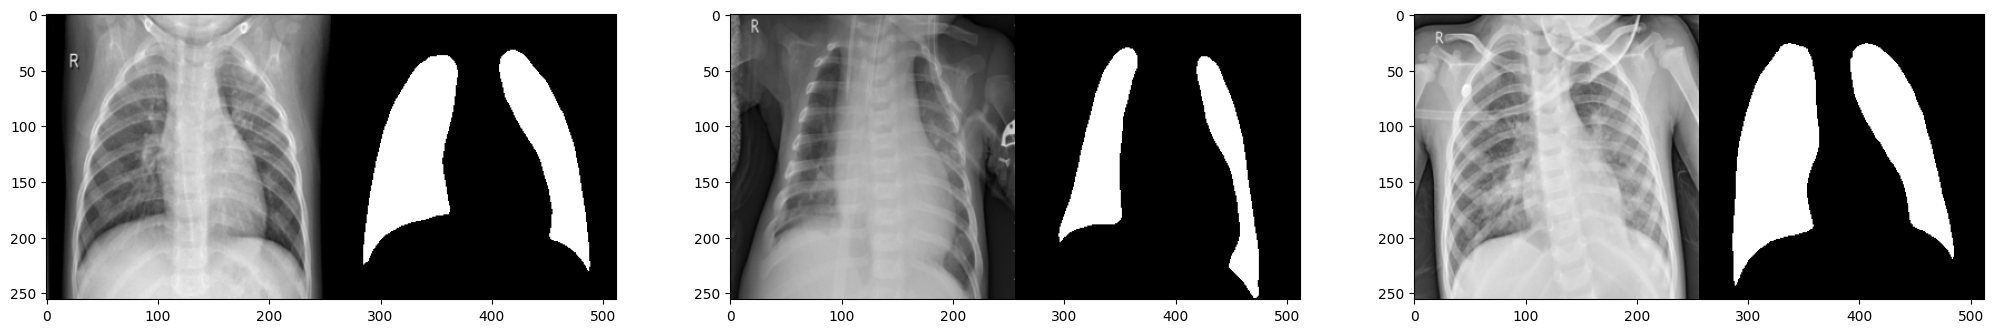

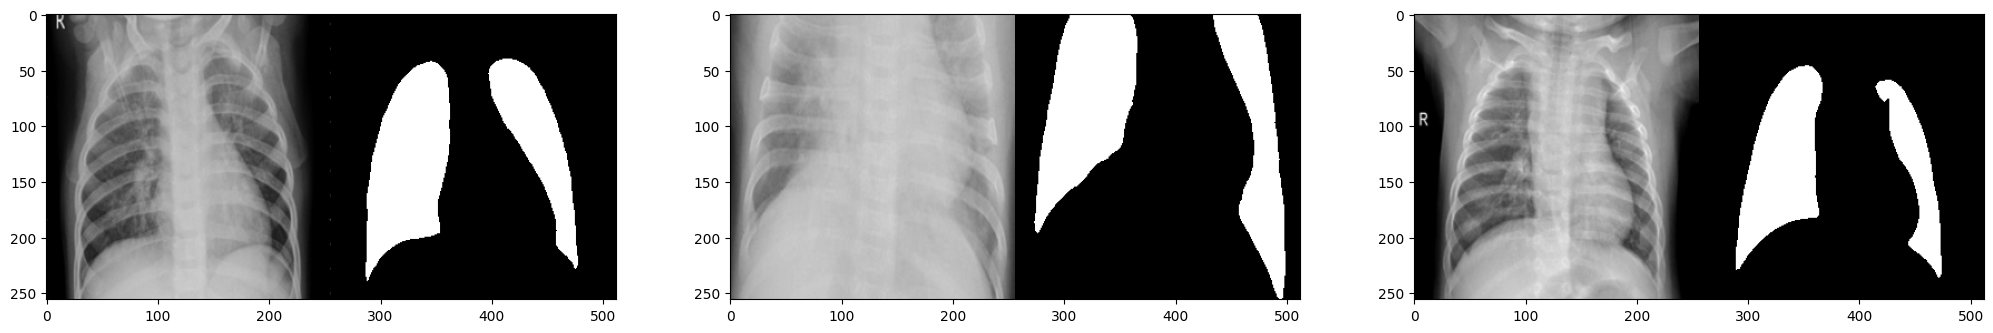

In [4]:
print("training set")
plotMask(X_covid,y_covid)
print("testing set")
plotMask(X_normal,y_normal)
print("training set")
plotMask(X_lung_opacity,y_lung_opacity)
print("testing set")
plotMask(X_viral_pneumonia,y_viral_pneumonia)

training set


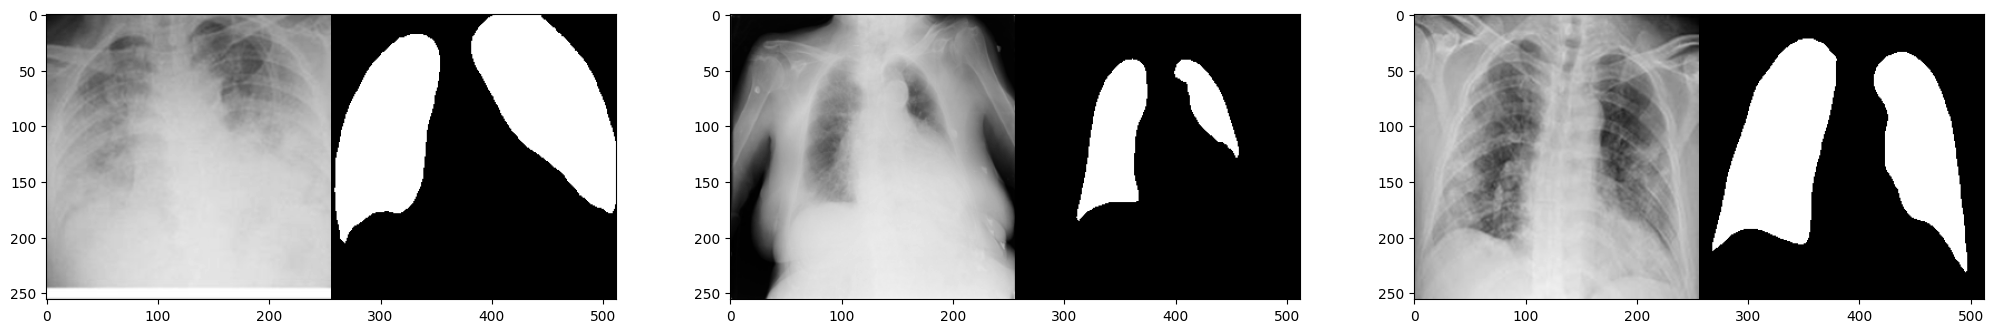

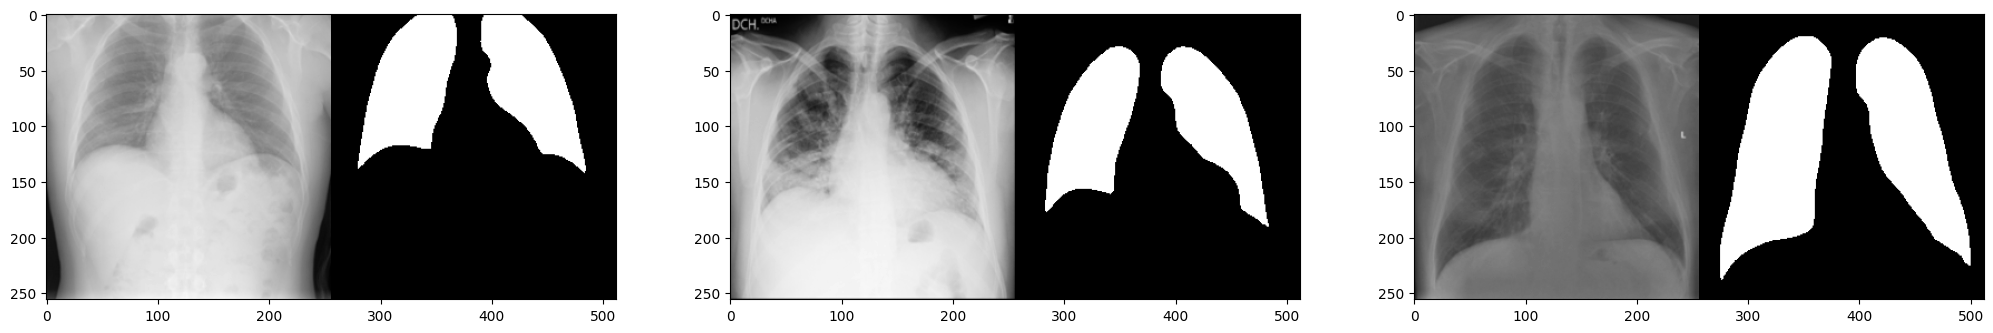

In [5]:
print("training set")
plotMask(X_data,y_data)

In [3]:
!pip install -U -q segmentation-models

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
model = sm.Unet('inceptionresnetv2', classes=1, activation='sigmoid',input_shape=(256, 256, 1),encoder_weights=None)

Segmentation Models: using `tf.keras` framework.


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.utils import to_categorical   
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="inceptionresnetv2.weights.h5"

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min',save_weights_only=True)



reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=25) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [early, reduceLROnPlat,checkpoint]

In [5]:
from sklearn.model_selection import train_test_split

train_vol, validation_vol, train_seg, validation_seg = train_test_split((X_data-127.0)/127.0, 
                                                            (y_data>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)


train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
                                                            test_size = 0.1, 
                                                            random_state = 2018)

NameError: name 'X_data' is not defined

In [6]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as keras
#from keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Flatten



def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def iou_score(y_pred, y_true, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
    iou = (intersection + smooth)/(union + smooth)
    return iou

In [7]:
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])


In [30]:
from IPython.display import clear_output
#tf.config.run_functions_eagerly(True)

loss_history = model.fit(x = train_vol, 
                       y = train_seg,
                         batch_size = 32,
                  epochs = 50,
                  validation_data =(test_vol,test_seg) ,
                  callbacks=callbacks_list)

Epoch 1/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - binary_accuracy: 0.7662 - dice_coef: 0.5499 - iou_score: 0.7768 - loss: 0.4501   
Epoch 1: val_loss improved from inf to 0.65595, saving model to inceptionresnetv2.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - binary_accuracy: 0.7670 - dice_coef: 0.5505 - iou_score: 0.7771 - loss: 0.4495 - val_binary_accuracy: 0.6764 - val_dice_coef: 0.3435 - val_iou_score: 0.7074 - val_loss: 0.6560 - learning_rate: 1.0000e-04
Epoch 2/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - binary_accuracy: 0.9693 - dice_coef: 0.7688 - iou_score: 0.8916 - loss: 0.2312
Epoch 2: val_loss improved from 0.65595 to 0.33282, saving model to inceptionresnetv2.weights.h5
137/137 ━━━━━━━━━━━━━━━━━━━━ 80s 586ms/step - binary_accuracy: 0.9693 - dice_coef: 0.7690 - iou_score: 0.8917 - loss: 0.2310 - val_binary_accuracy: 0.8915 - val_dice_coef: 0.6664 - val_iou_score: 0.8594 - val_loss: 0.3328 - learning_rate: 1.0000e-04
Epoch 3/50
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s

KeyboardInterrupt: 

In [8]:
model.load_weights('/kaggle/input/models/inceptionresnetv2.weights.h5')

#model.evaluate(validation_vol,validation_seg)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1042 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [9]:
model1 = sm.FPN('efficientnetb2', classes=1, activation='sigmoid',input_shape=(256, 256, 1),encoder_weights=None)
model1.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model1.load_weights("/kaggle/input/models/efficientnetb2.weights.h5")
#model1.evaluate(validation_vol,validation_seg)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 678 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [10]:
model2 = sm.Linknet('seresnext50', classes=1, activation='sigmoid',input_shape=(256, 256, 1),encoder_weights=None)
model2.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model2.load_weights("/kaggle/input/models/linkseresnext50.weights.h5")
#model2.evaluate(validation_vol,validation_seg)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1534 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [12]:
import os
import cv2
import numpy as np
from IPython.display import clear_output


input_base_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
output_base_path = '/kaggle/working/output/'  # Change this to your desired output path

# Create the output folder if it doesn't exist
os.makedirs(output_base_path, exist_ok=True)

# List of classes or folders
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Iterate through each class
for class_name in classes:
    input_folder = os.path.join(input_base_path, class_name, 'images')
    output_folder = os.path.join(output_base_path, class_name, 'segmented')

    # Create the output class folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # List all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.png') or f.endswith('.jpg')]

    # Iterate through each image
    for image_file in image_files:
        # Load the image
        image_path = os.path.join(input_folder, image_file)
        img = cv2.imread(image_path, 0)  # Load image in grayscale
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
        img = (img - 127.0) / 127.0
        img = img.reshape(1, 256, 256, 1)
        pred1 = model.predict(img)
        pred1 = pred1.reshape(256, 256, 1)
        
        pred2 = model1.predict(img)
        pred2 = pred2.reshape(256, 256, 1)
        
        pred3 = model2.predict(img)
        pred3 = pred3.reshape(256, 256, 1)
        
        
        new = np.ones((256, 256), dtype=float)
        newx = np.ones((256, 256), dtype=float)
        c = 256
        f = 0
        m = 256
        n = 0
        flag = 0
        img = img.reshape(256, 256, 1)
        for i in range(len(img)):
            count = 0
            for j in range(len(img)):
                if pred1[i][j] >= 0.4 or pred1[i][j] >= 0.4 or pred1[i][j] >= 0.4:
                    new[i][j] = img[i][j]
                    newx[i][j] = 0
                    c = min(c, j)
                    f = max(f, j)
                    flag = 1
                else:
                    count += 1
            if count == 256:
                if flag == 0:
                    n = max(n, i)
                else:
                    m = min(m, i)

        if m < 140:
            m = 256
        if f < 140:
            f = 256

        new = new[n:m, c:f]
        if new.size:
            new = cv2.resize(new, (256, 256), interpolation=cv2.INTER_NEAREST)

            # Overlay segmented regions on the original image
            original_image = cv2.imread(image_path)  # Load original image in BGR color format
            segmented_image = np.zeros_like(original_image, dtype=np.uint8)
            for i in range(256):
                for j in range(256):
                    if newx[i][j] == 0:
                        segmented_image[i][j] = original_image[i][j]

            # Save the segmented output
            output_path = os.path.join(output_folder, image_file.replace('.png', '_segmented.png'))
            cv2.imwrite(output_path, segmented_image)
            clear_output(wait=True)

print("Segmentation complete. Segmented images saved in the output folder.")


Segmentation complete. Segmented images saved in the output folder.


In [14]:
import shutil
shutil.make_archive("working", 'zip', "/kaggle/working/")

'/kaggle/working/working.zip'

In [1]:
##START HEREEE!!!!!!!!!!!

!pip install -U keras-cv-attention-models

  Obtaining dependency information for keras-cv-attention-models from https://files.pythonhosted.org/packages/ed/34/326174421f782fab59c96efcbbcfa2d4637e77243d5218888687e55ae54d/keras_cv_attention_models-1.4.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 kB 7.9 MB/s eta 0:00:00
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/f4/f0/21efef51304172736b823689aaf82f33dbc64f54e9b046b75f5212d5cee7/ftfy-6.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/fd/84/fd2ba7aafacbad3c4201d395674fc6348826569da3c0937e75505ead3528/wcwidth-0.2.13-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.3/796.3 kB 16.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-0.2.

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from keras_cv_attention_models import coatnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set your working directory
working_directory = "/kaggle/input/hidata/"
os.chdir(working_directory)

# Define input shape for grayscale images
input_shape = (256, 256, 1)  # Adjust based on your segmented images

# Load segmented data
X_data = []
y_data = []
limit_per_class = 3000  # Set the limit per class

# List of classes or folders
classes = ['COVID', 'Normal', 'Viral Pneumonia']

for class_name in classes:
    segmented_folder = os.path.join(working_directory, 'output', class_name, 'segmented')

    # List all image files in the segmented folder
    segmented_files = [f for f in os.listdir(segmented_folder) if f.endswith('_segmented.png')]
    
    # Initialize count for the class
    limit = 0
    
    # Iterate through each segmented image
    for segmented_file in segmented_files:
        # Load the segmented image in grayscale
        segmented_path = os.path.join(segmented_folder, segmented_file)
        img = cv2.imread(segmented_path, 0)  # The '0' flag loads images in grayscale

        # Resize image to input_shape if necessary
        img = cv2.resize(img, (256, 256))

        # Expand dimensions to fit input_shape (256, 256, 1)
        img = np.expand_dims(img, axis=-1)

        # Check if the limit for the class has been reached
        if limit < limit_per_class:
            # Append the image to X_data
            X_data.append(img)

            # Append the label to y_data (assuming 0-indexed classes)
            y_data.append(classes.index(class_name))
            
            # Increment the count for the class
            limit += 1

# Convert lists to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
len(X_data)

7345

In [4]:


# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create data generators with augmentation for the train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation and test sets

# Define batch size
batch_size = 32

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size)

In [6]:
from keras_cv_attention_models import coatnet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model = coatnet.CoAtNet0(input_shape = (256, 256, 1),num_classes=0)

flatten = tf.keras.layers.GlobalAveragePooling2D()(model.output)
drop_out = tf.keras.layers.Dropout(0.25)(flatten)
dense = tf.keras.layers.Dense(2048, activation = "relu")(drop_out)
drop_out = tf.keras.layers.Dropout(0.3)(flatten)
dense = tf.keras.layers.Dense(1024, activation = "relu")(drop_out)
prediction = tf.keras.layers.Dense(3, activation = "softmax", name = "prediction")(dense)
model = tf.keras.Model(model.input, prediction)

# Compile the model
loss = tf.keras.losses.sparse_categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-3)
metric = [tf.keras.metrics.sparse_categorical_accuracy]
model.compile(loss=loss, optimizer=opt, metrics=metric)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_sparse_categorical_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model with callbacks
epochs = 50  # Adjust as needed
hist = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


>>>> Load pretrained from: /root/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb
Epoch 1/50
147/147 [==============================] - ETA: 0s - loss: 2.1516 - sparse_categorical_accuracy: 0.4419
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.25935, saving model to /kaggle/working/best_model.h5
147/147 [==============================] - 122s 632ms/step - loss: 2.1516 - sparse_categorical_accuracy: 0.4419 - val_loss: 1.7653 - val_sparse_categorical_accuracy: 0.2594 - lr: 0.0010
Epoch 2/50
147/147 [==============================] - ETA: 0s - loss: 0.7841 - sparse_categorical_accuracy: 0.6117
Epoch 2:

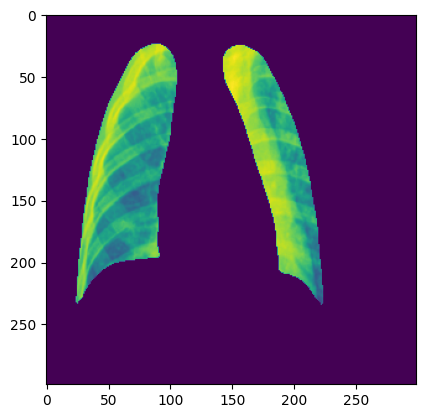

In [293]:
import matplotlib.pyplot as plt
img_x = cv2.imread("/kaggle/input/hidata/output/COVID/segmented/COVID-1010_segmented.png",0)

plt.imshow(img_x)

In [294]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [295]:
import matplotlib
#model_builder = keras.applications.xception.Xception
img_size = (256, 256)
# preprocess_input = keras.applications.xception.preprocess_input
# decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "stack_4_block_2_ffn_2_conv"
matplotlib.image.imsave("/kaggle/working/hi.jpg", img_x)
# The local path to our target image
img_path = "/kaggle/working/hi.jpg"

#display(Image(img_path))


In [296]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def convert_to_grayscale(img_array):
    # Assuming img_array is in shape (1, height, width, 3) and RGB format
    # Convert RGB to grayscale by taking the average across the color channels
    grayscale_img_array = tf.reduce_mean(img_array, axis=-1, keepdims=True)
    return grayscale_img_array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(convert_to_grayscale(img_array))
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 30ms/step


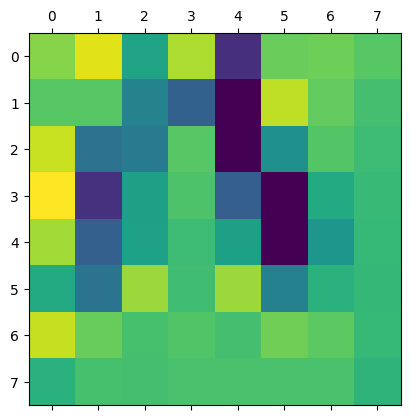

In [297]:
def get_img_array(img_path, size):
    # Load the image in grayscale
    img = keras.preprocessing.image.load_img(img_path, target_size=size, color_mode='grayscale')
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def preprocess_input(x):
    # Custom preprocessing for grayscale (normalize)
    return x / 255.0

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Load the model
#model = load_model("coat0-11.hdf5")
model.layers[-1].activation = None  # Remove softmax for prediction

# Prediction
preds = model.predict(img_array)

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="stack_4_block_2_ffn_2_conv")

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [265]:
heatmap1 = heatmap


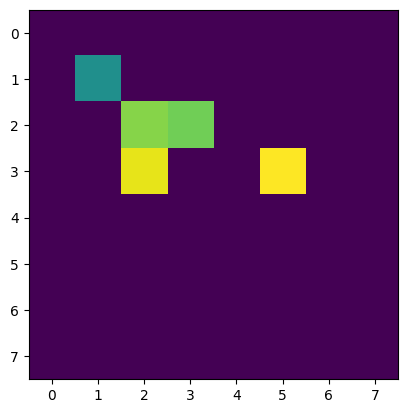

In [266]:
for i in range(8):
    for j in range(8):
        if heatmap1[i][j]>0.4:
            pass
            #print(i)
            #heatmap[i][j] =  0
        else:
            heatmap1[i][j]=  0
#heatmap1[9,11] = 0
plt.imshow(heatmap1)

In [267]:
jet_heatmap

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [268]:

#def save_and_display_gradcam(img_path, heatmap, cam_path="coatpneu1.jpg", alpha=0.4):
cam_path="/kaggle/working/coatpneu2.jpg" #required image
alpha=0.6
# Load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY )

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap1)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

target_color = np.array([0, 0, 127]) / 255.0  # Normalize color to match jet_colors scale
mask = np.all(np.isclose(jet_heatmap, target_color, atol=1/255), axis=-1)  # Tolerance for color matching

    # Set to black wherever the condition is met
jet_heatmap[mask] = [0, 0, 0]


# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)




# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * alpha + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
superimposed_img.save(cam_path)

# Display Grad CAM
#display(Image(cam_path))
    #return cam_path

/tmp/ipykernel_48/262709507.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


In [269]:
img = cv2.imread(cam_path)
b, g, r = cv2.split(img)
img = cv2.merge([r, g, b])

i = cv2.imread(cam_path)
b, g, r = cv2.split(i)
i = cv2.merge([r, g, b])


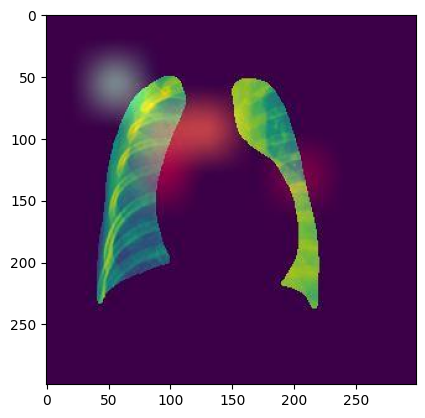

In [270]:
plt.imshow(i,cmap="gray")

In [60]:
light_orange = (0, 0, 0)
dark_orange = (110, 255, 255)
hsv_nemo = cv2.cvtColor(i, cv2.COLOR_RGB2HSV)

In [61]:
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)

In [62]:
result = cv2.bitwise_and(i, i, mask=mask)

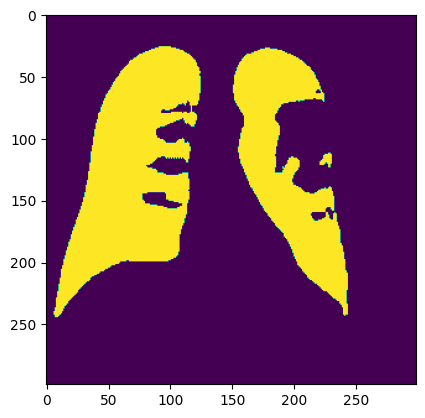

In [63]:
plt.imshow(mask)

In [64]:
mask[200][100]

0

In [65]:
flag = 0
for k in range(512):
    for j in range(512):
        if flag == 0:
            if mask[k][j]>0:
                img[k][j-5:j] = [200,0,0]
                flag = 1
        if flag == 1:
            if mask[k][j]==0:
                img[k][j-5:j]= [200,0,0]
                flag = 0

IndexError: index 299 is out of bounds for axis 0 with size 299

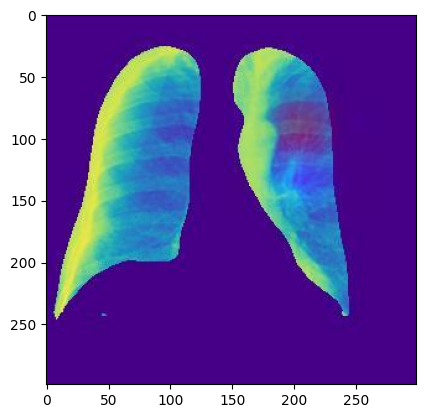

In [66]:
plt.imshow(img)

In [ ]:
matplotlib.image.imsave("coatmask1.jpg", img) #outline image